<a href="https://colab.research.google.com/github/pypratikyesankar9/NLP_demystified/blob/main/Named_entity_first_cut_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import gc

gc.collect()

98

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy

from sklearn import metrics
from sklearn import model_selection
from sklearn.datasets import fetch_20newsgroups
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from sklearn.svm import SVC


In [98]:
## loading the Dataset
data = pd.read_csv("ner_dataset.csv",encoding="latin1" )

In [99]:
##Dimension check
print(data.head())
print()
data.shape

    Sentence #           Word  POS Tag
0  Sentence: 1      Thousands  NNS   O
1          NaN             of   IN   O
2          NaN  demonstrators  NNS   O
3          NaN           have  VBP   O
4          NaN        marched  VBN   O



(1048575, 4)

In [100]:
##Identifying missing values
data.isnull().sum()

Sentence #    1000616
Word               10
POS                 0
Tag                 0
dtype: int64

Data Preprocessing

In [101]:
data = data.fillna(method='ffill')

data['Sentence #'].nunique(), data.Word.nunique(), data.Tag.nunique()

(47959, 35177, 17)

In [102]:
data['Sentence #'].nunique(), data.Word.nunique(), data.Tag.nunique()

(47959, 35177, 17)

In [103]:
data.shape

(1048575, 4)

In [ ]:
#### Optional, will show 1 example with spacy as well
##!pip install -U spacy==3.*
##!python -m spacy download en_core_web_sm
##!python -m spacy info

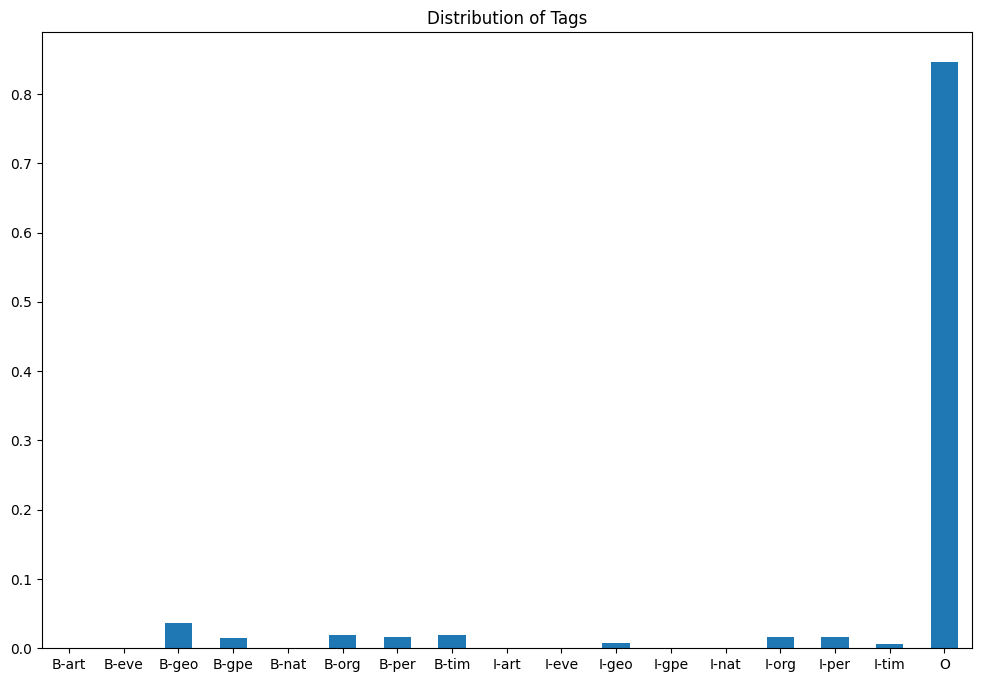

In [69]:
####Checking the distribution for Tag
bins, counts = np.unique(data.Tag, return_counts=True)
freq_series = pd.Series(counts/len(data))
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_xticklabels(bins, rotation=0)
ax.set_title('Distribution of Tags')
plt.show()

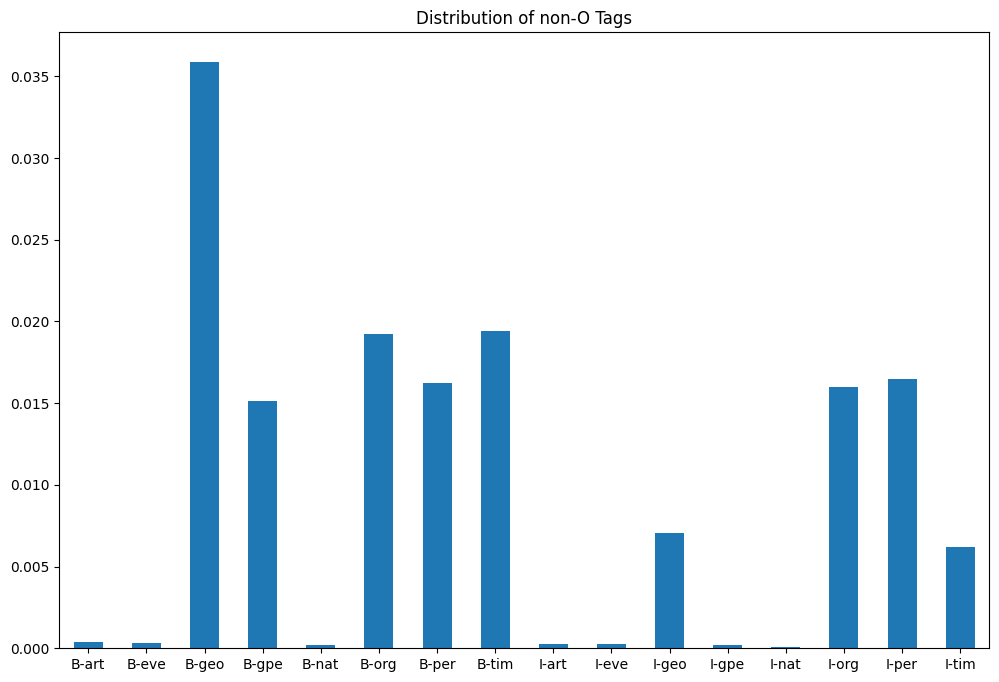

In [70]:

bins, counts = np.unique(data[data.Tag != 'O'].Tag, return_counts=True)
freq_series = pd.Series(counts/len(data))
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_xticklabels(bins, rotation=0)
ax.set_title('Distribution of non-O Tags')
plt.show()

In [71]:
data.groupby('Tag').size().reset_index(name='counts').sort_values(by = 'counts', ascending= False)

,Tag,counts
16,O,887908
2,B-geo,37644
7,B-tim,20333
5,B-org,20143
14,I-per,17251
6,B-per,16990
13,I-org,16784
3,B-gpe,15870
10,I-geo,7414
15,I-tim,6528


In [104]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [105]:

data["Sentence #"] = LabelEncoder().fit_transform(data["Sentence #"] )

In [74]:

data.head(30)

,Sentence #,Word,POS,Tag
0,0,Thousands,NNS,O
1,0,of,IN,O
2,0,demonstrators,NNS,O
3,0,have,VBP,O
4,0,marched,VBN,O
5,0,through,IN,O
6,0,London,NNP,B-geo
7,0,to,TO,O
8,0,protest,VB,O
9,0,the,DT,O


In [106]:
data.rename(columns={"Sentence #":"sentence_id","Word":"words","Tag":"labels"}, inplace =True)

In [76]:
##Lower case for words, and upper case for lables
data["labels"] = data["labels"].str.upper()
data["words"] = data["words"].str.lower()




In [77]:
###
X= data[["sentence_id","words"]]
Y =data["labels"]

In [78]:

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size =0.2)

In [79]:

#building up train data and test data
train_data = pd.DataFrame({"sentence_id":x_train["sentence_id"],"words":x_train["words"],"labels":y_train})
test_data = pd.DataFrame({"sentence_id":x_test["sentence_id"],"words":x_test["words"],"labels":y_test})

In [80]:
#### Validation data kept separately for final validation
val_data = test_data.copy()

In [81]:
X2= train_data[["sentence_id","words"]]
Y2 =train_data["labels"]

In [82]:
x_train, x_test, y_train, y_test = train_test_split(X2,Y2, test_size =0.2)

In [83]:

#re building the train data and test data
train_data = pd.DataFrame({"sentence_id":x_train["sentence_id"],"words":x_train["words"],"labels":y_train})
test_data = pd.DataFrame({"sentence_id":x_test["sentence_id"],"words":x_test["words"],"labels":y_test})

In [84]:
## dimensions of train, test and validation
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)



(671088, 3)
(167772, 3)
(209715, 3)


In [85]:
del X
del Y
del X2
del Y2


In [86]:
%%time
vectorizer = CountVectorizer(stop_words= "english")

CPU times: user 35 µs, sys: 0 ns, total: 35 µs
Wall time: 38.4 µs


In [87]:
%%time
x= vectorizer.fit_transform(train_data['words'].values.astype('U'))
x_test = vectorizer.transform(test_data['words'].values.astype('U'))
x_val = vectorizer.transform(val_data['words'].values.astype('U'))

CPU times: user 5.31 s, sys: 120 ms, total: 5.43 s
Wall time: 5.49 s


In [88]:
y = train_data['labels']
y_test = test_data['labels']
y_val = val_data['labels']

In [89]:
classes = np.unique(y)
classes = classes.tolist()

Linear classifier with SGD

In [41]:
#training the model
sgd = SGDClassifier()
sgd.partial_fit(x, y, classes)


SGDClassifier()

In [43]:
#Scoring the model on datasets
y_pred = sgd.predict(x)
y_test_pred = sgd.predict(x_test)
y_val_pred = sgd.predict(x_val)

In [44]:
print("Train F1-score:", f1_score(y,y_pred,average = "macro"))
print("Test F1-score:", f1_score(y_test,y_test_pred,average = "macro"))
print("Validation F1-score:", f1_score(y_val,y_val_pred,average = "macro"))

Train F1-score: 0.28765913495920076
Test F1-score: 0.28739343386464605
Validation F1-score: 0.28825320714004465


In [46]:
print(classification_report(y_pred=sgd.predict(x), y_true=y, labels = classes))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-ART       0.00      0.00      0.00       252
       B-EVE       0.00      0.00      0.00       210
       B-GEO       0.82      0.47      0.60     24169
       B-GPE       0.92      0.68      0.78     10169
       B-NAT       0.00      0.00      0.00       134
       B-ORG       0.85      0.20      0.32     12812
       B-PER       0.82      0.40      0.54     10940
       B-TIM       0.89      0.64      0.75     13002
       I-ART       0.00      0.00      0.00       184
       I-EVE       0.00      0.00      0.00       178
       I-GEO       0.79      0.31      0.45      4784
       I-GPE       0.00      0.00      0.00       131
       I-NAT       0.00      0.00      0.00        30
       I-ORG       0.65      0.12      0.20     10604
       I-PER       0.81      0.19      0.30     10917
       I-TIM       0.00      0.00      0.00      4119
           O       0.90      1.00      0.95    568453

    accuracy              

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
new_classes = classes.copy()
new_classes.pop()
new_classes


['B-ART',
 'B-EVE',
 'B-GEO',
 'B-GPE',
 'B-NAT',
 'B-ORG',
 'B-PER',
 'B-TIM',
 'I-ART',
 'I-EVE',
 'I-GEO',
 'I-GPE',
 'I-NAT',
 'I-ORG',
 'I-PER',
 'I-TIM']

In [53]:
print(classification_report(y_pred=sgd.predict(x), y_true=y, labels = new_classes))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-ART       0.00      0.00      0.00       252
       B-EVE       0.00      0.00      0.00       210
       B-GEO       0.82      0.47      0.60     24169
       B-GPE       0.92      0.68      0.78     10169
       B-NAT       0.00      0.00      0.00       134
       B-ORG       0.85      0.20      0.32     12812
       B-PER       0.82      0.40      0.54     10940
       B-TIM       0.89      0.64      0.75     13002
       I-ART       0.00      0.00      0.00       184
       I-EVE       0.00      0.00      0.00       178
       I-GEO       0.79      0.31      0.45      4784
       I-GPE       0.00      0.00      0.00       131
       I-NAT       0.00      0.00      0.00        30
       I-ORG       0.65      0.12      0.20     10604
       I-PER       0.81      0.19      0.30     10917
       I-TIM       0.00      0.00      0.00      4119

   micro avg       0.85      0.37      0.52    102635
   macro avg       0.41   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
##Naive Bayes classifier for multinomial models
nb = MultinomialNB(alpha=0.01)
nb.partial_fit(x, y, classes)


MultinomialNB(alpha=0.01)

In [48]:
#Scoring the model on datasets
y_pred = nb.predict(x)
y_test_pred = nb.predict(x_test)
y_val_pred = nb.predict(x_val)

In [49]:
print("Train F1-score:", f1_score(y,y_pred,average = "macro"))
print("Test F1-score:", f1_score(y_test,y_test_pred,average = "macro"))
print("Validation F1-score:", f1_score(y_val,y_val_pred,average = "macro"))

Train F1-score: 0.5086906954845322
Test F1-score: 0.41163096944291777
Validation F1-score: 0.41402026876637693


In [55]:
print(classification_report(y_pred=y_pred, y_true=y, labels = new_classes))

              precision    recall  f1-score   support

       B-ART       0.92      0.27      0.42       252
       B-EVE       0.68      0.30      0.41       210
       B-GEO       0.81      0.77      0.79     24169
       B-GPE       0.93      0.94      0.94     10169
       B-NAT       0.78      0.24      0.37       134
       B-ORG       0.83      0.40      0.54     12812
       B-PER       0.77      0.76      0.77     10940
       B-TIM       0.88      0.75      0.81     13002
       I-ART       1.00      0.10      0.19       184
       I-EVE       1.00      0.02      0.03       178
       I-GEO       0.76      0.54      0.63      4784
       I-GPE       0.84      0.24      0.38       131
       I-NAT       1.00      0.07      0.12        30
       I-ORG       0.69      0.21      0.32     10604
       I-PER       0.81      0.79      0.80     10917
       I-TIM       0.60      0.09      0.16      4119

   micro avg       0.82      0.64      0.72    102635
   macro avg       0.83   

In [90]:
##Passive aggresive

pa =PassiveAggressiveClassifier()
pa.partial_fit(x, y, classes)


PassiveAggressiveClassifier()

In [91]:
#Scoring the model on datasets
y_pred = pa.predict(x)
y_test_pred = pa.predict(x_test)
y_val_pred = pa.predict(x_val)

In [92]:
print("Train F1-score:", f1_score(y,y_pred,average = "macro"))
print("Test F1-score:", f1_score(y_test,y_test_pred,average = "macro"))
print("Validation F1-score:", f1_score(y_val,y_val_pred,average = "macro"))

Train F1-score: 0.52249615751443
Test F1-score: 0.4620799884054096
Validation F1-score: 0.47058916311507915


In [93]:
print(classification_report(y_pred=y_pred, y_true=y, labels = new_classes))

              precision    recall  f1-score   support

       B-ART       0.04      0.30      0.08       265
       B-EVE       0.66      0.28      0.39       210
       B-GEO       0.80      0.77      0.78     24161
       B-GPE       0.92      0.94      0.93     10125
       B-NAT       0.41      0.38      0.39       137
       B-ORG       0.73      0.43      0.55     12900
       B-PER       0.71      0.76      0.73     10901
       B-TIM       0.86      0.72      0.79     13148
       I-ART       0.55      0.14      0.22       187
       I-EVE       0.65      0.07      0.13       157
       I-GEO       0.68      0.55      0.61      4712
       I-GPE       0.63      0.48      0.54       130
       I-NAT       0.56      0.28      0.38        32
       I-ORG       0.56      0.27      0.36     10650
       I-PER       0.78      0.80      0.79     11022
       I-TIM       0.43      0.17      0.24      4183

   micro avg       0.76      0.65      0.70    102920
   macro avg       0.62   

**The results from the first approach are not encouraging , and may require further exploration**

**Second approach : Using Sequenctial Conditional Random Field (CRF) model**

In [107]:
!pip install sklearn-crfsuite

In [108]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers


In [109]:
data.head()

,sentence_id,words,POS,labels
0,0,Thousands,NNS,O
1,0,of,IN,O
2,0,demonstrators,NNS,O
3,0,have,VBP,O
4,0,marched,VBN,O


In [110]:
# A class to retrieve the sentences from the dataset
class getsentence(object):

    def __init__(self, data):
        self.n_sent = 1.0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["words"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["labels"].values.tolist())]
        self.grouped = self.data.groupby("sentence_id").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [111]:
getter = getsentence(data)

In [112]:
sentences = getter.sentences
#ths is how a sentence will look like.
print(sentences[1])

[('Iranian', 'JJ', 'B-gpe'), ('officials', 'NNS', 'O'), ('say', 'VBP', 'O'), ('they', 'PRP', 'O'), ('expect', 'VBP', 'O'), ('to', 'TO', 'O'), ('get', 'VB', 'O'), ('access', 'NN', 'O'), ('to', 'TO', 'O'), ('sealed', 'JJ', 'O'), ('sensitive', 'JJ', 'O'), ('parts', 'NNS', 'O'), ('of', 'IN', 'O'), ('the', 'DT', 'O'), ('plant', 'NN', 'O'), ('Wednesday', 'NNP', 'B-tim'), (',', ',', 'O'), ('after', 'IN', 'O'), ('an', 'DT', 'O'), ('IAEA', 'NNP', 'B-org'), ('surveillance', 'NN', 'O'), ('system', 'NN', 'O'), ('begins', 'VBZ', 'O'), ('functioning', 'VBG', 'O'), ('.', '.', 'O')]


In [114]:
#Lets find the number of words in the dataset
words = list(set(data["words"].values))
n_words = len(words)
print(n_words)

35177


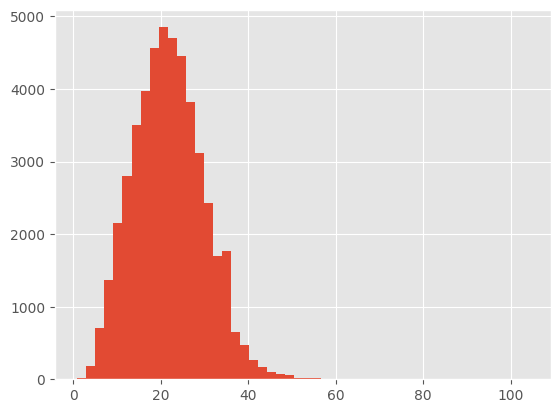

In [115]:
#Lets visualize how the sentences are distributed by their length
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [116]:
#Lets find out the longest sentence length in the dataset
maxlen = max([len(s) for s in sentences])
print ('Maximum sentence length:', maxlen)

Maximum sentence length: 104


In [118]:
#Words tagged as B-org
data.loc[data['labels'] == 'B-org', 'words'].head()

97             Labor
154    International
215             IAEA
234         European
248             U.N.
Name: words, dtype: object

In [119]:
#Words tagged as I-org
data.loc[data['labels'] == 'I-org', 'words'].head()

98      Party
155    Atomic
156    Energy
157    Agency
235     Union
Name: words, dtype: object

In [122]:
import seaborn as sns

#Words distribution across Tags
plt.figure(figsize=(15, 5))
ax = sns.countplot('labels', data= data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

TypeError: countplot() got multiple values for argument 'data'

<Figure size 1500x500 with 0 Axes>

In [123]:
from itertools import chain

import nltk
import sklearn
import scipy.stats

import sklearn_crfsuite
from sklearn_crfsuite import scorers,CRF
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn_crfsuite import metrics

In [128]:
# Feature set
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

In [130]:
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

In [131]:
#Creating the train and test set
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

In [132]:
#Creating the CRF model
crf = CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)


In [136]:
#Data analysis
import pandas as pd
import numpy as np
#Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#Modeling
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
# from sklearn_crfsuite import CRF, scorers, metrics
# import sklearn_crfsuite
# from sklearn_crfsuite import scorers
# from sklearn_crfsuite import metrics
# from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import scipy.stats



In [137]:
!pip install eli5
import eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107720 sha256=35553fe4e49e7750cb3cfc7adcbc21669c351b580fc13951075b9a5cefa24530
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [ ]:
%%time
#We predcit using the same 5 fold cross validation
pred = cross_val_predict(estimator=crf, X=X, y=y, cv=5)